# Helper Functions

In [13]:
from typing import NamedTuple, Optional, Tuple, Generator

import torch
import numpy as np
from matplotlib import pyplot as plt
from skimage.draw import circle_perimeter_aa


class CircleParams(NamedTuple):
    row: int
    col: int
    radius: int
    
    def to_numpy(self) -> np.ndarray:
        """
        Return np.array([row, col, radius])
        """
        return np.array([
            self.row,
            self.col,
            self.radius
        ], dtype=np.float32)
    
    def from_tensor(tensor_cir: torch.Tensor) -> CircleParams:
        """
        Class Method
        ------------
        tensor_cir: tensor in shape [1,3]
        
        Return a CircleParams construct with the the three elements
        in tensor_cir, with [[row, col, radius]] correspondingly
        """
        return CircleParams(
            tensor_cir[0].item(),
            tensor_cir[1].item(),
            tensor_cir[2].item()
        )
    

def draw_circle(img: np.ndarray, row: int, col: int, radius: int) -> np.ndarray:
    """
    Draw a circle in a numpy array, inplace.
    The center of the circle is at (row, col) and the radius is given by radius.
    The array is assumed to be square.
    Any pixels outside the array are ignored.
    Circle is white (1) on black (0) background, and is anti-aliased.
    """
    rr, cc, val = circle_perimeter_aa(row, col, radius)
    valid = (rr >= 0) & (rr < img.shape[0]) & (cc >= 0) & (cc < img.shape[1])
    img[rr[valid], cc[valid]] = val[valid]
    return img


def noisy_circle(
    img_size: int, min_radius: float, max_radius: float, noise_level: float
) -> Tuple[np.ndarray, CircleParams]:
    """
    Draw a circle in a numpy array, with normal noise.
    """

    # Create an empty image
    img = np.zeros((img_size, img_size))

    radius = np.random.randint(min_radius, max_radius)

    # x,y coordinates of the center of the circle
    row, col = np.random.randint(img_size, size=2)

    # Draw the circle inplace
    draw_circle(img, row, col, radius)
    # show_circle(img)

    added_noise = np.random.normal(0.5, noise_level, img.shape)
    img += added_noise

    return img, CircleParams(row, col, radius)


def show_circle(img: np.ndarray):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.set_title('Circle')
    plt.show()


def generate_examples(
    noise_level: float = 0.5,
    img_size: int = 100,
    min_radius: Optional[int] = None,
    max_radius: Optional[int] = None,
    dataset_path: str = 'ds',
) -> Generator[Tuple[np.ndarray, CircleParams], None, None]:
    if not min_radius:
        min_radius = img_size // 10
    if not max_radius:
        max_radius = img_size // 2
    assert max_radius > min_radius, "max_radius must be greater than min_radius"
    assert img_size > max_radius, "size should be greater than max_radius"
    assert noise_level >= 0, "noise should be non-negative"

    params = f"noise_level={noise_level}, img_size={img_size}, min_radius={min_radius}, max_radius={max_radius}, dataset_path={dataset_path}"
    print(f"Using parameters: {params}")
    while True:
        img, params = noisy_circle(
            img_size=img_size, min_radius=min_radius, max_radius=max_radius, noise_level=noise_level
        )
        yield img, params


def iou(a: CircleParams, b: CircleParams) -> float:
    """Calculate the intersection over union of two circles"""
    r1, r2 = a.radius, b.radius
    d = np.linalg.norm(np.array([a.row, a.col]) - np.array([b.row, b.col]))
    if d > r1 + r2:
        return 0
    if d <= abs(r1 - r2):
        return 1
    r1_sq, r2_sq = r1**2, r2**2
    d1 = (r1_sq - r2_sq + d**2) / (2 * d)
    d2 = d - d1
    h1 = r1_sq * np.arccos(d1 / r1)
    h2 = d1 * np.sqrt(r1_sq - d1**2)
    h3 = r2_sq * np.arccos(d2 / r2)
    h4 = d2 * np.sqrt(r2_sq - d2**2)
    intersection = h1 + h2 + h3 + h4
    union = np.pi * (r1_sq + r2_sq) - intersection
    return intersection / union

# Dataset Initialization & Preprocessing

In [14]:
from torchvision.datasets.vision import List
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms


class Dataset(torch.utils.data.Dataset):
    """
    Dataset class to hold the image array and corresponding 
    labels, the CircleParams object array.
    """
    def __init__(self, img_src: np.ndarray, circ_src: List[CircleParams]):
        self.images = img_src
        self.circles = circ_src

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return (
            np.expand_dims(
                np.float32(self.images[idx]),
                axis = 0
            ), 
            self.circles[idx]
        )

def noise_removal():
    pass
    
def dataset_generation(
    store_path: str,
    num: int=1e4
) -> Dataset:
    """
    store_path: path to store the generated numpy array object for
                failure recovery
    num: number of data points to generate
    
    Generate a dataset using the generator and store the feature and
    labels in the given path.
    
    Return a Dataset object ready to be wrapped by data loader
    """
    
    img_gen = generate_examples()

    feat = []
    lab = []
    for i in range(int(num)):
        data_point = next(img_gen)
        feat.append(
            data_point[0]
        )
        lab.append(data_point[1].to_numpy())
    
    feat = np.array(feat)
    lab = np.array(lab)
    
    with open(store_path + "_feat.npy", 'wb') as f:
        np.save(f, feat)
    with open(store_path + "_lab.npy", 'wb') as f:
        np.save(f, lab)
    
    return Dataset(
        feat,
        lab
    )

# reproductivity 
torch.manual_seed(39)
np.random.seed(39)

train_data = dataset_generation("./train", 3*1e4)
valid_data = dataset_generation("./valid", 1e3)
test_data = dataset_generation("./test", 1e3)



Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path=ds
Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path=ds
Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path=ds


# Architecture

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5), nn.BatchNorm2d(32), nn.GELU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3), nn.BatchNorm2d(64), nn.GELU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3), nn.BatchNorm2d(128), nn.GELU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3), nn.BatchNorm2d(256), nn.GELU(),
            nn.Conv2d(256, 512, 3), nn.BatchNorm2d(512), nn.GELU(),
            nn.Conv2d(512, 1024, 3), nn.BatchNorm2d(1024), nn.GELU(),
            nn.Conv2d(1024, 6, 1), nn.BatchNorm2d(6), nn.GELU()
        )
        self.fc = nn.Sequential(nn.Linear(6 * 4 * 4, 256), nn.GELU(), nn.Linear(256, 16), nn.GELU())
        self.last = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.last(x)

        return x


net = Net()

# Training

In [16]:
from torch.nn.modules.loss import MSELoss
import torch.optim as optim

from typing import BinaryIO

epoch_num = 200
batch_size = 128

lr = 1e-3
momentum = 0.9
weight_decay = 1e-5

criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)


train_loader = torch.utils.data.DataLoader(
    train_data, batch_size = batch_size
)
valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size = batch_size
)

def logger(output, fp: BinaryIO) -> None:
    """
    Helper function to record the output to a given file while printing
    """
    print(output)
    fp.write(bytes(output+'\n', 'utf-8'))

def save_losses(path: str, losses: List) -> None:
    """
    Save the recorded loss in .npy
    """
    with open(path, "wb") as f:
        np.save(f, np.array(losses, dtype=np.float32))
    

In [17]:
import time

train_batch_losses, valid_batch_losses = [], []
train_losses, valid_losses = [], []
best_val = float("inf")
cnt_model = 0
fp = open("./train_log.log", "wb")

logger(
    f"Training Start at {time.strftime('%H:%M:%S', time.localtime())}",
    fp
)

for epoch in range(epoch_num): 
    time_start = time.time()
    
    # training
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = net(inputs)
        loss = criterion1(outputs, labels) + 0.1 * criterion2(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() 
        train_batch_losses.append(loss.item())
    # MSE-mean & L1-mean
    train_losses.append(running_loss / len(train_loader))
    
    # validation
    valid_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valid_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            pred = net(inputs)
            loss = criterion1(pred, labels) + 0.1 * criterion2(pred, labels)
            valid_loss += loss.item()
            valid_batch_losses.append(loss.item())
            
        if valid_loss < best_val:
            logger(
                f"{'-'*50}\nSaving Best Model cnt={cnt_model}\nLoss: {best_val:.5f} -> {valid_loss:.5f}\n{'-'*50}",
                fp
            )
            torch.save(net.state_dict(), f"./best_model{cnt_model}.pt")
            best_val = valid_loss
            cnt_model+=1
    valid_losses.append(valid_loss / len(valid_loader))
    
            
    if epoch % 5 == 0:
        logger(
            f'\n\nTraining Loss Accumulate {running_loss:.5f}. Training Loss per Batch {running_loss / len(train_loader):.5f}',
            fp
        )
        logger(
            f'Validation Loss Accumulate {valid_loss:.5f}. Validation Loss per Batch {valid_loss / len(valid_loader):.5f}\n\n',
            fp
        )
    
    logger(
        f"Epoch {epoch+1} in {time.time() - time_start:.2f}",
        fp
    )
logger(
    f"Training End at {time.strftime('%H:%M:%S', time.localtime())}",
    fp
)


save_losses("./train_batch_loss.npy", train_batch_losses)
save_losses("./train_loss.npy", train_losses)
save_losses("./valid_batch_loss.npy", valid_batch_losses)
save_losses("./valid_loss.npy", valid_losses)
logger("Loss saved...", fp)

    

Training Start at 00:17:55
--------------------------------------------------
Saving Best Model cnt=0
Loss: inf -> 3056.81848
--------------------------------------------------


Training Loss Accumulate 193350.30673. Training Loss per Batch 822.76726
Validation Loss Accumulate 3056.81848. Validation Loss per Batch 382.10231


Epoch 1 in 15.98
--------------------------------------------------
Saving Best Model cnt=1
Loss: 3056.81848 -> 797.64194
--------------------------------------------------
Epoch 2 in 15.96
--------------------------------------------------
Saving Best Model cnt=2
Loss: 797.64194 -> 346.47652
--------------------------------------------------
Epoch 3 in 16.01
--------------------------------------------------
Saving Best Model cnt=3
Loss: 346.47652 -> 270.41808
--------------------------------------------------
Epoch 4 in 16.07
--------------------------------------------------
Saving Best Model cnt=4
Loss: 270.41808 -> 249.14219
---------------------------------

Epoch 102 in 16.42
Epoch 103 in 16.40
Epoch 104 in 16.41
Epoch 105 in 16.41


Training Loss Accumulate 1322.27489. Training Loss per Batch 5.62670
Validation Loss Accumulate 174.48096. Validation Loss per Batch 21.81012


Epoch 106 in 16.37
Epoch 107 in 16.28
Epoch 108 in 16.07
Epoch 109 in 15.95
Epoch 110 in 15.93


Training Loss Accumulate 1081.70178. Training Loss per Batch 4.60299
Validation Loss Accumulate 98.50024. Validation Loss per Batch 12.31253


Epoch 111 in 15.93
Epoch 112 in 15.88
Epoch 113 in 15.88
Epoch 114 in 15.88
Epoch 115 in 15.91


Training Loss Accumulate 450.33269. Training Loss per Batch 1.91631
Validation Loss Accumulate 98.67196. Validation Loss per Batch 12.33399


Epoch 116 in 15.89
Epoch 117 in 15.90
Epoch 118 in 15.92
Epoch 119 in 15.98
Epoch 120 in 15.97


Training Loss Accumulate 448.09527. Training Loss per Batch 1.90679
Validation Loss Accumulate 121.29586. Validation Loss per Batch 15.16198


Epoch 121 in 16.00
Epoch 122 in 16.04
Epoch 123 in 16.09
Ep

In [19]:
def inspect_prediction(net, valid_data, num, batch_size=2):
    valid_loader_out = torch.utils.data.DataLoader(
        valid_data, batch_size=batch_size
    )

    mapping = {
        0: "x",
        1: "y",
        2: "radius"
    }
    cnt = 0
    
    for i, j in valid_loader_out:
        i, j = i.to(device), j.to(device)
#         i = i[0:1]
#         j = j[0:1]
        print(f"i shape {i.shape}")

        predition = net(i)
        criterion1 = nn.MSELoss()
        criterion2 = nn.L1Loss()
        loss = criterion1(predition, j) + 0.1*criterion2(predition, j)
        print(f"loss {loss.shape}")
        print(f"loss item {loss.item()}")
#         print(f"prediction result \n{predition}")
#         print(j)
        print(predition-j)
        print(torch.sum((predition-j)**2))
        print(torch.sum((predition-j)**2)/len(predition[0]))
        print(predition.shape)
        
#         for i in range(3):
#             print(f"{mapping[i]}: {predition[0][i]} | {j[0][i]}")
        print(f"{'-'*50}")
        if cnt == num:
            break
        cnt+=1

def draw_pred_true(pred_cir, true_cir):
    
    show_circle(
        draw_circle(
            np.zeros((100,100)),
            pred_cir.row,
            pred_cir.col,
            pred_cir.radius
        )
    )
    show_circle(
        draw_circle(
            np.zeros((100,100)),
            true_cir.row,
            true_cir.col,
            true_cir.radius
        )
    )


In [21]:
def test_model(
    net: Net, test_data: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return model's test loss and IOU of each predictions
    """
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size = 128
    )
    
    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()
    
    test_losses = []
    ious = []
    for i, data in enumerate(test_loader, 0):
        x, y = data[0].to(device), data[1].to(device)
        
        pred = net(x)
        loss = criterion1(pred, y) + 0.1*criterion2(pred, y)
        
        test_losses.append(loss.item())
        
        for i in range(len(pred)):
            
            ious.append(
                iou(
                    CircleParams.from_tensor(pred[i]),
                    CircleParams.from_tensor(y[i])
                )
            )
    
    return np.array(test_losses), np.array(ious)

def draw_figure(
    train: np.ndarray, valid: np.ndarray, loss_name: str
) -> None:
    """
    Plot a figure for training and validation loss
    """
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(train, label="Train Loss")
    ax.plot(valid, label="Validation Loss")
    ax.legend(loc='best')
    ax.set_title("Loss During Training", fontsize=16)
    ax.set_xlabel("Epochs", fontsize=14)
    ax.set_ylabel("Loss: {}".format(loss_name), fontsize=14)
    plt.savefig("./loss_figure.pdf")
    plt.show()


expamle = test_model(net, test_data)

    

In [22]:
expamle

(array([10.06043053, 16.28272438, 21.61396217, 15.44885159, 20.21316719,
        30.16310692, 18.0650425 , 24.67841339]),
 array([0.98285472, 0.91442159, 1.        , 0.98697703, 0.9734212 ,
        0.90808674, 1.        , 0.94903856, 1.        , 1.        ,
        0.98207505, 1.        , 0.99995193, 0.92685554, 0.90772305,
        0.99961369, 0.94632877, 1.        , 0.89227904, 0.92205018,
        0.95941501, 0.99748045, 0.99648965, 0.9429427 , 0.95487526,
        0.90128581, 0.99807608, 1.        , 1.        , 1.        ,
        0.97822472, 0.94732079, 1.        , 0.98650414, 0.75021842,
        1.        , 0.99156904, 0.93647964, 0.98731254, 1.        ,
        0.93210815, 0.93855816, 0.98511858, 0.97012492, 0.74563974,
        0.99945296, 1.        , 0.88961224, 0.99122007, 0.92622255,
        0.82479041, 0.87864967, 0.67840815, 0.81343121, 0.99160731,
        0.94350006, 1.        , 0.95433847, 0.98024481, 0.87785788,
        0.98800653, 1.        , 0.99883358, 0.98338365, 0.6728

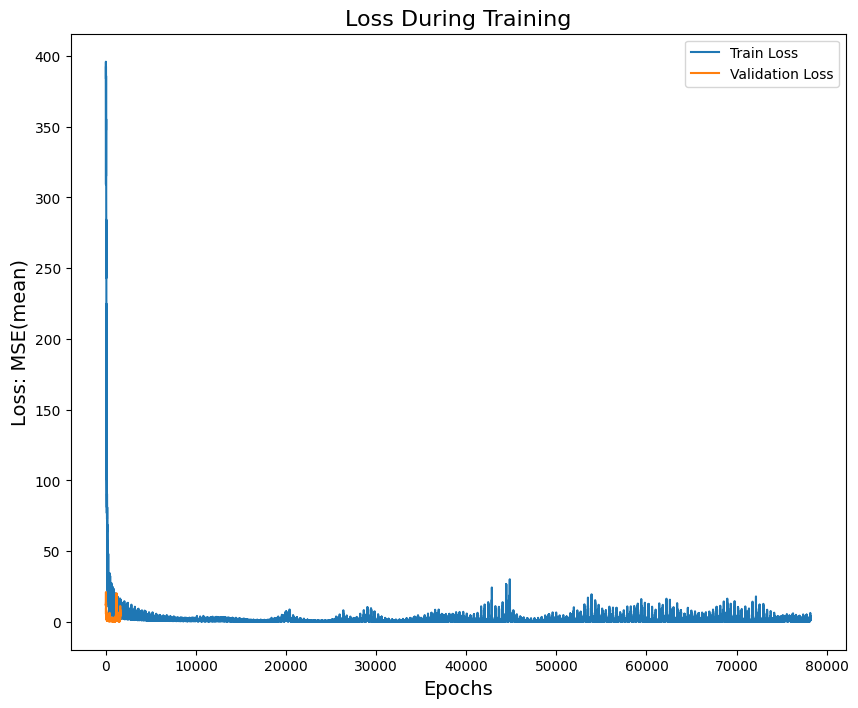

In [104]:
draw_figure(train_losses, valid_losses, "MSE(mean)")

In [ ]:
#make an iterator from test_loader
#Get a batch of training images
test_iterator = iter(test_loader)
images, labels = test_iterator.next()

results = net(images)
_, predicted = torch.max(results, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

fig2 = plt.figure()
for i in range(4):
   fig2.add_subplot(rows, columns, i+1)
   plt.title('truth ' + classes[labels[i]] + ': predict ' + classes[predicted[i]])
   img = images[i] / 2 + 0.5     # this is to unnormalize the image
   img = torchvision.transforms.ToPILImage()(img)
   plt.imshow(img)
plt.show()

Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path=ds


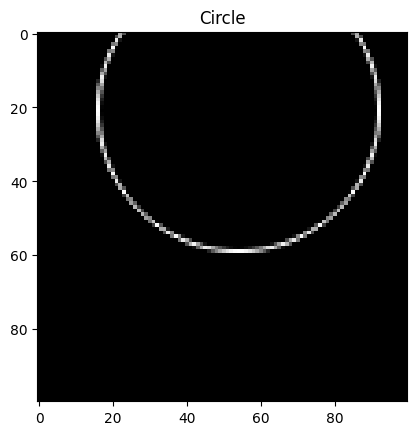

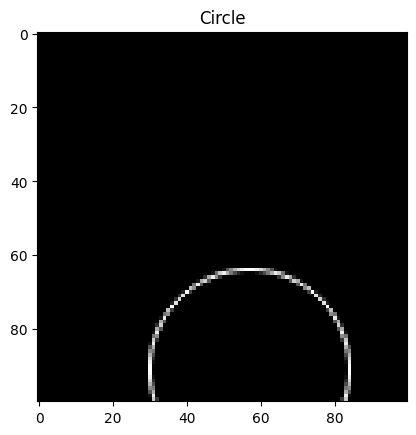

In [13]:
samples = generate_examples()
ens = []

for i in range(2):
  point = next(samples)  
  show_circle(point[0])
#   ens.append(point[0])
  # print(point[1])
  # print(point[0][0])
# print(np.array(ens).shape)
# print(point[0].dtype)
# print(np.float32(point[0]).dtype)

# print(point[0].shape)
# print(np.expand_dims(point[0], axis=0).shape)

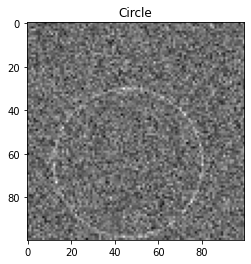

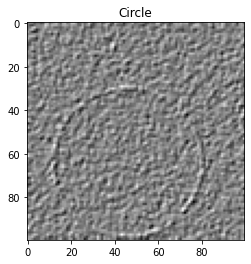

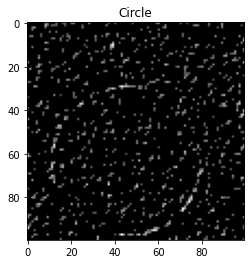

In [179]:
from skimage.filters.thresholding import try_all_threshold
from scipy.ndimage import gaussian_filter, median_filter, sobel
from skimage.filters import try_all_threshold

img_new = gaussian_filter(point[0], 1)
dx = sobel(point[0],0)
dy = sobel(point[0],-1)
dd = dx+dy
show_circle(point[0])
show_circle(dd)

total = np.sum(dd!=0)
for th in range(200,500):
  dd[dd < th/100] = 0
  if np.sum(dd!=0) < (total * 0.1):
    show_circle(dd)
    break
  



In [32]:
valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=1
)

mapping = {
    0: "x",
    1: "y",
    2: "radius"
}
cnt = 0
for i, j in valid_loader:
    i, j = i.to(device), j.to(device)
    
    predition = net(i)
    for i in range(3):
        print(f"{mapping[i]}: {predition[0][i]} | {j[0][i]}")
    print(f"{'-'*50}")
    if cnt == 10:
        break
    cnt+=1

x: -37.25458526611328 | 20.0
y: -26.33516502380371 | 3.0
radius: 63.809326171875 | 10.0
--------------------------------------------------
x: 21.394775390625 | 68.0
y: 92.54981231689453 | 50.0
radius: 63.89730453491211 | 19.0
--------------------------------------------------
x: 45.53569030761719 | 47.0
y: 65.54328918457031 | 70.0
radius: 28.067344665527344 | 34.0
--------------------------------------------------
x: 45.820655822753906 | 51.0
y: 70.60324096679688 | 72.0
radius: 37.851932525634766 | 41.0
--------------------------------------------------
x: 12.758113861083984 | 35.0
y: 62.210235595703125 | 46.0
radius: 18.685401916503906 | 10.0
--------------------------------------------------
x: 27.734073638916016 | 22.0
y: 40.706565856933594 | 37.0
radius: 37.33659744262695 | 45.0
--------------------------------------------------
x: 85.37934112548828 | 92.0
y: 58.07134246826172 | 58.0
radius: 30.33843231201172 | 38.0
--------------------------------------------------
x: 0.9340553283